# PHA Modeling

In [1]:
FORECAST_OUTPUT_HOUR = 14

## Setting up parameters and connecting to Virtual SQL Tables

### Notebook package dependencies

In [2]:
import os, types
import pandas as pd
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)
import numpy as np
import ibm_db_dbi as dbi
import ibm_boto3

from os import environ
from io import BytesIO
from datetime import datetime, timezone, timedelta
from ibm_watson_studio_lib import access_project_or_space
from botocore.client import Config

 ***
### Required environment variables
* BATCH_ID: string id for correlation
* RUN_DATETIME_UTC: string iso format of UTC datetime (ie. date.isoformat())
* LOAD_FORECAST_TABLE: the name of the watson query connection name
* BUCKET_NAME: name of the cos bucket
* OUTPUT_FILE: cos file path to save the output data frame\
***

In [3]:
dt_now = datetime.now(timezone.utc)
environ['BATCH_ID'] = datetime.fromisoformat('2022-05-02 16:25:22.524494+00:00').strftime('%Y%m%d%H%M')
environ['BATCH_ID'] = dt_now.strftime('%Y%m%d%H%M')
environ['RUN_DATETIME_UTC'] = dt_now.isoformat()
environ['LOAD_FORECAST_TABLE'] = 'NCEMC.dep_load_forecast_local'
environ['BUCKET_NAME'] = 'peakprediction1bdev-donotdelete-pr-uro5imnbrzzacl'
environ['OUTPUT_FILE'] = 'process_data/dep/stf/test.parquet'

In [4]:
project_token = 'p-c0350211750f8cbcb967f8cdd40da80fd326ddf1'
cos_api_key = 'n_1maQytHdUEzrwJcPfyVwbKjBWl6ZFGHDU1zHQXnQjC'

#### Fetch incoming parameters from environment variables

In [5]:
#get the batch id
batch_id = environ.get('BATCH_ID', None) #This will return the batch id or a default value of None
if batch_id == None:
    raise ValueError('BATCH_ID environment variable is missing')

#get the run_datetime_utc from
run_datetime_utc = environ.get('RUN_DATETIME_UTC', None)
if run_datetime_utc == None:
    raise ValueError('RUN_DATETIME_UTC environment variable is missing')
#parse the run_datetime_utc variable
try:
    run_datetime_utc = datetime.fromisoformat(run_datetime_utc)
except:
    raise ValueError('RUN_DATETIME_UTC environment variable could not be converted to a valid datetime format. Please use iso format')

#get the table name
load_forecast_table = environ.get('LOAD_FORECAST_TABLE', None)

#get bucket name
bucket_name = environ.get('BUCKET_NAME', None)

#get output file path
output_file = environ.get('OUTPUT_FILE', None)

print(f'batch_id: {batch_id}')
print(f'run_datetime_utc: {run_datetime_utc}')
print(f'load_forecast_table: {load_forecast_table}')

recent_datetime_hour = run_datetime_utc.replace(microsecond=0,second=0,minute=0, tzinfo=None)
print(f'recent_forecast_datetime: {recent_datetime_hour}')

batch_id: 202206020238
run_datetime_utc: 2022-06-02 02:38:26.440152+00:00
load_forecast_table: NCEMC.dep_load_forecast_local
recent_forecast_datetime: 2022-06-02 02:00:00


#### Configure notebook dependencies/libraries

In [6]:
project = access_project_or_space({'token': project_token})

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_api_key,
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

#### Functions

In [7]:
def get_connection_string_and_table(connected_data_props: dict) -> tuple[str,str]:
    """
    Returns a tuple of the connection string and table name from the Watson Connected Data properties dictionary
    """
    conn_str = 'DATABASE={};HOSTNAME={};PORT={};PROTOCOL=TCPIP;Security=SSL;Authentication=GSSplugin;APIKEY={}'.format(
        connected_data_props['database'],
        connected_data_props['host'],
        connected_data_props['port'],
        connected_data_props['api_key']
    )
    table_name = ".".join(f'"{x}"' for x in connected_data_props['datapath'][1:].split('/'))
    return (conn_str, table_name)

## Import and format raw load forecast data

In [8]:
%%time
#get connected data information then query
props = project.get_connected_data(load_forecast_table)
(conn_str, table) = get_connection_string_and_table(props)

conn = dbi.connect(conn_str)

#floor to the hour and drop the timezone info (dv is timezone niave)
forecast_date = recent_datetime_hour #run_datetime_utc.replace(microsecond=0,second=0,minute=0, tzinfo=None)

sql = f'select * from {table} '
print(sql)
# sql = f'select max("Output_timestamp_utc") as "Output_timestamp_utc" from {table}'
load_forecast = pd.read_sql_query(sql, con=conn)

if len(load_forecast) > 0:
#the timezone information is not persisted via data virtualization. So we need to provide time zone information
    load_forecast.loc[:,'Output_timestamp_utc'] = load_forecast['Output_timestamp_utc'].dt.tz_localize('utc')
    load_forecast.loc[:,'Fcst_datetime_utc'] = load_forecast['Fcst_datetime_utc'].dt.tz_localize('utc')
    load_forecast.loc[:,'Output_timestamp'] = load_forecast['Output_timestamp_utc'].dt.tz_convert('US/Eastern')
    load_forecast.loc[:,'Fcst_datetime'] = load_forecast['Fcst_datetime_utc'].dt.tz_convert('US/Eastern')
    
load_forecast

select * from "NCEMC"."dep_load_forecast_local" 
CPU times: user 1min 23s, sys: 10.8 s, total: 1min 34s
Wall time: 3min 48s


,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW
0,2018-07-03 03:10:43-04:00,2018-07-03 07:10:43+00:00,2018-07-15 02:00:00-04:00,2018-07-15 06:00:00+00:00,7389.114
1,2018-07-03 03:10:43-04:00,2018-07-03 07:10:43+00:00,2018-07-15 03:00:00-04:00,2018-07-15 07:00:00+00:00,6845.716
2,2018-07-03 03:10:43-04:00,2018-07-03 07:10:43+00:00,2018-07-15 04:00:00-04:00,2018-07-15 08:00:00+00:00,6537.308
3,2018-07-03 03:10:43-04:00,2018-07-03 07:10:43+00:00,2018-07-15 05:00:00-04:00,2018-07-15 09:00:00+00:00,6327.991
4,2018-07-03 03:10:43-04:00,2018-07-03 07:10:43+00:00,2018-07-15 06:00:00-04:00,2018-07-15 10:00:00+00:00,6079.750
...,...,...,...,...,...
11819731,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 00:00:00-05:00,2022-01-12 05:00:00+00:00,8398.585
11819732,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 01:00:00-05:00,2022-01-12 06:00:00+00:00,8204.750
11819733,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 02:00:00-05:00,2022-01-12 07:00:00+00:00,8226.737
11819734,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 03:00:00-05:00,2022-01-12 08:00:00+00:00,8359.669


In [9]:
load_forecast['Fcst_datetime'] = pd.to_datetime(load_forecast['Fcst_datetime'])

load_forecast['Fcst_Date'] = load_forecast['Fcst_datetime'].dt.date
load_forecast['Fcst_Date'] = pd.to_datetime(load_forecast['Fcst_Date'])

load_forecast['Fcst_Hour'] = load_forecast['Fcst_datetime'].dt.hour

load_forecast.tail()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour
11819731,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 00:00:00-05:00,2022-01-12 05:00:00+00:00,8398.585,2022-01-12,0
11819732,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 01:00:00-05:00,2022-01-12 06:00:00+00:00,8204.750,2022-01-12,1
11819733,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 02:00:00-05:00,2022-01-12 07:00:00+00:00,8226.737,2022-01-12,2
11819734,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 03:00:00-05:00,2022-01-12 08:00:00+00:00,8359.669,2022-01-12,3
11819735,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 04:00:00-05:00,2022-01-12 09:00:00+00:00,8591.614,2022-01-12,4


In [10]:
load_forecast['ahead_hours'] = round((load_forecast['Fcst_datetime']-load_forecast['Output_timestamp']).dt.total_seconds()/3600)
load_forecast['ahead_days'] = (load_forecast['ahead_hours']/24).astype(int)
load_forecast.tail()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days
11819731,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 00:00:00-05:00,2022-01-12 05:00:00+00:00,8398.585,2022-01-12,0,272.0,11
11819732,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 01:00:00-05:00,2022-01-12 06:00:00+00:00,8204.750,2022-01-12,1,273.0,11
11819733,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 02:00:00-05:00,2022-01-12 07:00:00+00:00,8226.737,2022-01-12,2,274.0,11
11819734,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 03:00:00-05:00,2022-01-12 08:00:00+00:00,8359.669,2022-01-12,3,275.0,11
11819735,2021-12-31 16:11:22-05:00,2021-12-31 21:11:22+00:00,2022-01-12 04:00:00-05:00,2022-01-12 09:00:00+00:00,8591.614,2022-01-12,4,276.0,11


In [11]:
load_forecast.shape

(11819736, 9)

In [12]:
load_forecast = load_forecast[(load_forecast['ahead_hours'] <= 24)].copy()
load_forecast.shape

(843722, 9)

#### Selecting the forecast output hour to develop the model on

In [13]:
load_forecast['Output_Hour'] = load_forecast['Output_timestamp'].dt.hour
load_forecast = load_forecast[(load_forecast['Output_Hour'] == FORECAST_OUTPUT_HOUR)].copy().reset_index(drop=True)
load_forecast = load_forecast[load_forecast['Output_timestamp']>='2018-07-03']
load_forecast.tail()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour
33884,2021-12-31 14:11:21-05:00,2021-12-31 19:11:21+00:00,2022-01-01 10:00:00-05:00,2022-01-01 15:00:00+00:00,6167.432,2022-01-01,10,20.0,0,14
33885,2021-12-31 14:11:21-05:00,2021-12-31 19:11:21+00:00,2022-01-01 11:00:00-05:00,2022-01-01 16:00:00+00:00,6463.387,2022-01-01,11,21.0,0,14
33886,2021-12-31 14:11:21-05:00,2021-12-31 19:11:21+00:00,2022-01-01 12:00:00-05:00,2022-01-01 17:00:00+00:00,6591.943,2022-01-01,12,22.0,0,14
33887,2021-12-31 14:11:21-05:00,2021-12-31 19:11:21+00:00,2022-01-01 13:00:00-05:00,2022-01-01 18:00:00+00:00,6668.585,2022-01-01,13,23.0,0,14
33888,2021-12-31 14:11:21-05:00,2021-12-31 19:11:21+00:00,2022-01-01 14:00:00-05:00,2022-01-01 19:00:00+00:00,6777.973,2022-01-01,14,24.0,1,14


In [14]:
load_forecast.shape

(33864, 10)

In [15]:
load_forecast = load_forecast.sort_values(by=['Fcst_Date', 'Fcst_Hour', 'ahead_hours']).reset_index(drop=True)
load_forecast.head(72)

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14
5,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 20:00:00-04:00,2018-07-04 00:00:00+00:00,11374.391,2018-07-03,20,6.0,0,14
6,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 21:00:00-04:00,2018-07-04 01:00:00+00:00,10985.718,2018-07-03,21,7.0,0,14
7,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 22:00:00-04:00,2018-07-04 02:00:00+00:00,10582.274,2018-07-03,22,8.0,0,14
8,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 23:00:00-04:00,2018-07-04 03:00:00+00:00,9760.202,2018-07-03,23,9.0,0,14
9,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-04 00:00:00-04:00,2018-07-04 04:00:00+00:00,8847.215,2018-07-04,0,10.0,0,14


## Developing features on Load Forecast Data

### Hour Bunching Feature

In [16]:
load_forecast['Fcst_MW_lag1'] = load_forecast['Fcst_MW'].shift(1)
load_forecast['Fcst_Chng'] = load_forecast['Fcst_MW']/load_forecast['Fcst_MW_lag1'] - 1
# load_forecast.head()

In [17]:
def hr_bunch (df, hour, pct_chng, bunch_flag):
    
    df[bunch_flag]= np.where((((df[hour] > 4) & (df[hour] < 10)) | ((df[hour] > 13) & df[hour] < 21)) & ((df[pct_chng] >= -0.005) & (df[pct_chng] <= 0.005)), 1, 0)
    return df

In [18]:
load_forecast = hr_bunch(load_forecast, 'Fcst_Hour', 'Fcst_Chng', 'Fcst_Bunch')
load_forecast['Fcst_Bunch_lag1'] = load_forecast['Fcst_Bunch'].shift(1, fill_value=0)
load_forecast['Fcst_Bunch_lead1'] = load_forecast['Fcst_Bunch'].shift(-1, fill_value=0)

load_forecast.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_MW_lag1,Fcst_Chng,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,NaN,NaN,0,0,0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,11978.183,0.014756,0,0,0
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,12154.937,0.006120,0,0,0
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,12229.326,-0.007772,0,0,0
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,12134.275,-0.019267,0,0,0


### Forecasted Peak and Peak Hour Flag

In [19]:
load_forecast['Fcst_Peak'] = load_forecast.groupby(['Output_timestamp'])['Fcst_MW'].transform('max')

In [20]:
def fcst_peak_flag (df, fcst_mw, fcst_peak, fcst_peak_flag):
    
    df[fcst_peak_flag]= np.where((df[fcst_mw] == df[fcst_peak]), 1, 0)
    return df

In [21]:
load_forecast = fcst_peak_flag(load_forecast, 'Fcst_MW', 'Fcst_Peak', 'Fcst_Peak_Flag')
load_forecast['Fcst_Peak_Flag_lag1'] = load_forecast['Fcst_Peak_Flag'].shift(1, fill_value=0)
load_forecast['Fcst_Peak_Flag_lead1'] = load_forecast['Fcst_Peak_Flag'].shift(-1, fill_value=0)
load_forecast.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_MW_lag1,Fcst_Chng,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,NaN,NaN,0,0,0,12229.326,0,0,0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,11978.183,0.014756,0,0,0,12229.326,0,0,1
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,12154.937,0.006120,0,0,0,12229.326,1,0,0
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,12229.326,-0.007772,0,0,0,12229.326,0,1,0
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,12134.275,-0.019267,0,0,0,12229.326,0,0,0


### Rolling 24hr rank of forecasted MW

In [22]:
load_forecast['day_hour_rank'] = load_forecast.groupby(['Output_timestamp'])['Fcst_MW'].rank(method='min', ascending=False)
load_forecast['day_hour_rank_lag1'] = load_forecast['day_hour_rank'].shift(1)
load_forecast['day_hour_rank_lead1'] = load_forecast['day_hour_rank'].shift(-1)

load_forecast.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_MW_lag1,Fcst_Chng,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,NaN,NaN,0,0,0,12229.326,0,0,0,4.0,NaN,2.0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,11978.183,0.014756,0,0,0,12229.326,0,0,1,2.0,4.0,1.0
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,12154.937,0.006120,0,0,0,12229.326,1,0,0,1.0,2.0,3.0
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,12229.326,-0.007772,0,0,0,12229.326,0,1,0,3.0,1.0,5.0
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,12134.275,-0.019267,0,0,0,12229.326,0,0,0,5.0,3.0,6.0


### Clean up dataframe

In [23]:
load_forecast = load_forecast.drop(columns=['Fcst_MW_lag1', 'Fcst_Chng', 'Fcst_Peak'])
load_forecast.head(72)

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,0,0,0,0,0,0,4.0,NaN,2.0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,0,0,0,0,0,1,2.0,4.0,1.0
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,0,0,0,1,0,0,1.0,2.0,3.0
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,0,0,0,0,1,0,3.0,1.0,5.0
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,0,0,0,0,0,0,5.0,3.0,6.0
5,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 20:00:00-04:00,2018-07-04 00:00:00+00:00,11374.391,2018-07-03,20,6.0,0,14,0,0,0,0,0,0,6.0,5.0,7.0
6,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 21:00:00-04:00,2018-07-04 01:00:00+00:00,10985.718,2018-07-03,21,7.0,0,14,0,0,0,0,0,0,7.0,6.0,9.0
7,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 22:00:00-04:00,2018-07-04 02:00:00+00:00,10582.274,2018-07-03,22,8.0,0,14,0,0,0,0,0,0,9.0,7.0,11.0
8,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 23:00:00-04:00,2018-07-04 03:00:00+00:00,9760.202,2018-07-03,23,9.0,0,14,0,0,0,0,0,0,11.0,9.0,14.0
9,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-04 00:00:00-04:00,2018-07-04 04:00:00+00:00,8847.215,2018-07-04,0,10.0,0,14,0,0,0,0,0,0,14.0,11.0,16.0


## Import and format raw historical load data

In [24]:
%%time
#get connected data information then query
table_name = 'NCEMC.vw_dep_load_historical'
props = project.get_connected_data(table_name)
(conn_str, table) = get_connection_string_and_table(props)

conn = dbi.connect(conn_str)

#floor to the hour and drop the timezone info (dv is timezone niave)
forecast_date = recent_datetime_hour #run_datetime_utc.replace(microsecond=0,second=0,minute=0, tzinfo=None)

sql = f'select * from {table} '
print(sql)
# sql = f'select max("Output_timestamp_utc") as "Output_timestamp_utc" from {table}'
load = pd.read_sql_query(sql, con=conn)

if len(load) > 0:
#the timezone information is not persisted via data virtualization. So we need to provide time zone information
    load.loc[:,'Datetime_utc'] = load['Datetime_utc'].dt.tz_localize('utc')
    load.loc[:,'Datetime'] = load['Datetime_utc'].dt.tz_convert('US/Eastern')
    
load

select * from "NCEMC"."vw_dep_load_historical" 
CPU times: user 1.66 s, sys: 27.5 ms, total: 1.69 s
Wall time: 4.54 s


,Datetime_utc,Datetime,load
0,2021-01-01 05:00:00+00:00,2021-01-01 00:00:00-05:00,6097.7505
1,2021-01-01 06:00:00+00:00,2021-01-01 01:00:00-05:00,5807.4741
2,2021-01-01 07:00:00+00:00,2021-01-01 02:00:00-05:00,5630.0845
3,2021-01-01 08:00:00+00:00,2021-01-01 03:00:00-05:00,5490.2915
4,2021-01-01 09:00:00+00:00,2021-01-01 04:00:00-05:00,5429.9282
...,...,...,...
56253,2018-12-29 16:00:00+00:00,2018-12-29 11:00:00-05:00,6313.8457
56254,2018-12-29 17:00:00+00:00,2018-12-29 12:00:00-05:00,6262.2974
56255,2018-12-29 18:00:00+00:00,2018-12-29 13:00:00-05:00,6124.2041
56256,2018-12-29 19:00:00+00:00,2018-12-29 14:00:00-05:00,6026.0063


In [25]:
load['Datetime_utc'] = pd.to_datetime(load['Datetime_utc'])
load['Datetime'] = pd.to_datetime(load['Datetime'])
load['Date'] = load['Datetime'].dt.date
load['Date'] = pd.to_datetime(load['Date'])
load['HE'] = load['Datetime'].dt.hour

load = load.rename(columns={'load':'Actual_MW'})
load = load.sort_values(by=['Date', 'HE']).reset_index(drop=True)
load

,Datetime_utc,Datetime,Actual_MW,Date,HE
0,2016-01-01 06:00:00+00:00,2016-01-01 01:00:00-05:00,5324.438500,2016-01-01,1
1,2016-01-01 07:00:00+00:00,2016-01-01 02:00:00-05:00,5137.217800,2016-01-01,2
2,2016-01-01 08:00:00+00:00,2016-01-01 03:00:00-05:00,4970.378400,2016-01-01,3
3,2016-01-01 09:00:00+00:00,2016-01-01 04:00:00-05:00,4881.221200,2016-01-01,4
4,2016-01-01 10:00:00+00:00,2016-01-01 05:00:00-05:00,4916.134300,2016-01-01,5
...,...,...,...,...,...
56253,2022-06-01 22:00:00+00:00,2022-06-01 18:00:00-04:00,12211.732422,2022-06-01,18
56254,2022-06-01 23:00:00+00:00,2022-06-01 19:00:00-04:00,12103.419922,2022-06-01,19
56255,2022-06-02 00:00:00+00:00,2022-06-01 20:00:00-04:00,11795.833008,2022-06-01,20
56256,2022-06-02 01:00:00+00:00,2022-06-01 21:00:00-04:00,11222.679688,2022-06-01,21


In [26]:
load['Year'] = load['Date'].dt.year
load['month_of_year'] = load['Date'].dt.month
load['day_of_week'] = load['Date'].dt.dayofweek #Monday=0, Sunday=6
load["Is_Weekend"] = np.where(load.day_of_week > 4, 1, 0)
load.tail()

,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend
56253,2022-06-01 22:00:00+00:00,2022-06-01 18:00:00-04:00,12211.732422,2022-06-01,18,2022,6,2,0
56254,2022-06-01 23:00:00+00:00,2022-06-01 19:00:00-04:00,12103.419922,2022-06-01,19,2022,6,2,0
56255,2022-06-02 00:00:00+00:00,2022-06-01 20:00:00-04:00,11795.833008,2022-06-01,20,2022,6,2,0
56256,2022-06-02 01:00:00+00:00,2022-06-01 21:00:00-04:00,11222.679688,2022-06-01,21,2022,6,2,0
56257,2022-06-02 02:00:00+00:00,2022-06-01 22:00:00-04:00,10743.403320,2022-06-01,22,2022,6,2,0


## Combining Actual and Forecast Datasets to Create Modeling Dataset

In [27]:
load_combined = pd.merge(load_forecast, load, how="inner", left_on=['Fcst_Date', 'Fcst_Hour'], right_on=['Date', 'HE'])
load_combined.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,0,0,0,0,0,0,4.0,NaN,2.0,2018-07-03 19:00:00+00:00,2018-07-03 15:00:00-04:00,12315.052,2018-07-03,15,2018,7,1,0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,0,0,0,0,0,1,2.0,4.0,1.0,2018-07-03 20:00:00+00:00,2018-07-03 16:00:00-04:00,12502.806,2018-07-03,16,2018,7,1,0
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,0,0,0,1,0,0,1.0,2.0,3.0,2018-07-03 21:00:00+00:00,2018-07-03 17:00:00-04:00,12492.765,2018-07-03,17,2018,7,1,0
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,0,0,0,0,1,0,3.0,1.0,5.0,2018-07-03 22:00:00+00:00,2018-07-03 18:00:00-04:00,12461.293,2018-07-03,18,2018,7,1,0
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,0,0,0,0,0,0,5.0,3.0,6.0,2018-07-03 23:00:00+00:00,2018-07-03 19:00:00-04:00,12332.375,2018-07-03,19,2018,7,1,0


In [28]:
load_combined.shape

(33861, 28)

## Developing Various Peak Windows Features on Combined Load Data

### Create peak window targets

In [29]:
load_combined['Act_Peak'] = load_combined.groupby('Output_timestamp')['Actual_MW'].transform('max')
load_combined['mw_lag1'] = load_combined['Actual_MW'].shift(1)
load_combined['mw_lag2'] = load_combined['Actual_MW'].shift(2)
load_combined['mw_lag3'] = load_combined['Actual_MW'].shift(3)


load_combined = load_combined.sort_values(by=['Date', 'HE']).reset_index(drop=True)
load_combined.tail()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend,Act_Peak,mw_lag1,mw_lag2,mw_lag3
33856,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 18:00:00-04:00,2022-06-01 22:00:00+00:00,12248.983,2022-06-01,18,4.0,0,14,0,0,1,1,0,0,1.0,3.0,2.0,2022-06-01 22:00:00+00:00,2022-06-01 18:00:00-04:00,12211.732422,2022-06-01,18,2022,6,2,0,12325.912109,12325.912109,12130.613281,11959.724609
33857,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 19:00:00-04:00,2022-06-01 23:00:00+00:00,12188.912,2022-06-01,19,5.0,0,14,1,0,0,0,1,0,2.0,1.0,6.0,2022-06-01 23:00:00+00:00,2022-06-01 19:00:00-04:00,12103.419922,2022-06-01,19,2022,6,2,0,12325.912109,12211.732422,12325.912109,12130.613281
33858,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 20:00:00-04:00,2022-06-02 00:00:00+00:00,11784.942,2022-06-01,20,6.0,0,14,0,1,0,0,0,0,6.0,2.0,8.0,2022-06-02 00:00:00+00:00,2022-06-01 20:00:00-04:00,11795.833008,2022-06-01,20,2022,6,2,0,12325.912109,12103.419922,12211.732422,12325.912109
33859,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 21:00:00-04:00,2022-06-02 01:00:00+00:00,11314.377,2022-06-01,21,7.0,0,14,0,0,0,0,0,0,8.0,6.0,10.0,2022-06-02 01:00:00+00:00,2022-06-01 21:00:00-04:00,11222.679688,2022-06-01,21,2022,6,2,0,12325.912109,11795.833008,12103.419922,12211.732422
33860,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 22:00:00-04:00,2022-06-02 02:00:00+00:00,10787.490,2022-06-01,22,8.0,0,14,0,0,0,0,0,0,10.0,8.0,12.0,2022-06-02 02:00:00+00:00,2022-06-01 22:00:00-04:00,10743.403320,2022-06-01,22,2022,6,2,0,12325.912109,11222.679688,11795.833008,12103.419922


In [30]:
def peak_windows (df, Actual_MW, mw_lag1, mw_lag2, mw_lag3, Act_Peak, peak_hr, two_hr_window, three_hr_window, four_hr_window):
    
    df[peak_hr] = np.where((df[Actual_MW] == df[Act_Peak]), 1, 0)
    df[two_hr_window] = np.where((df[Actual_MW] == df[Act_Peak]) | (df[mw_lag1] == df[Act_Peak]), 1, 0)
    df[three_hr_window] = np.where((df[Actual_MW] == df[Act_Peak]) | (df[mw_lag1] == df[Act_Peak]) | (df[mw_lag2] == df[Act_Peak]), 1, 0)
    df[four_hr_window] = np.where((df[Actual_MW] == df[Act_Peak]) | (df[mw_lag1] == df[Act_Peak]) | (df[mw_lag2] == df[Act_Peak]) | (df[mw_lag3] == df[Act_Peak]), 1, 0)
    return df

In [31]:
load_combined = peak_windows(load_combined, 'Actual_MW', 'mw_lag1', 'mw_lag2', 'mw_lag3', 'Act_Peak', 'Peak_hr', 'two_hr_window', 'three_hr_window', 'four_hr_window')
load_combined.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend,Act_Peak,mw_lag1,mw_lag2,mw_lag3,Peak_hr,two_hr_window,three_hr_window,four_hr_window
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 15:00:00-04:00,2018-07-03 19:00:00+00:00,11978.183,2018-07-03,15,1.0,0,14,0,0,0,0,0,0,4.0,NaN,2.0,2018-07-03 19:00:00+00:00,2018-07-03 15:00:00-04:00,12315.052,2018-07-03,15,2018,7,1,0,12502.806,NaN,NaN,NaN,0,0,0,0
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 16:00:00-04:00,2018-07-03 20:00:00+00:00,12154.937,2018-07-03,16,2.0,0,14,0,0,0,0,0,1,2.0,4.0,1.0,2018-07-03 20:00:00+00:00,2018-07-03 16:00:00-04:00,12502.806,2018-07-03,16,2018,7,1,0,12502.806,12315.052,NaN,NaN,1,1,1,1
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 17:00:00-04:00,2018-07-03 21:00:00+00:00,12229.326,2018-07-03,17,3.0,0,14,0,0,0,1,0,0,1.0,2.0,3.0,2018-07-03 21:00:00+00:00,2018-07-03 17:00:00-04:00,12492.765,2018-07-03,17,2018,7,1,0,12502.806,12502.806,12315.052,NaN,0,1,1,1
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,0,0,0,0,1,0,3.0,1.0,5.0,2018-07-03 22:00:00+00:00,2018-07-03 18:00:00-04:00,12461.293,2018-07-03,18,2018,7,1,0,12502.806,12492.765,12502.806,12315.052,0,0,1,1
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,0,0,0,0,0,0,5.0,3.0,6.0,2018-07-03 23:00:00+00:00,2018-07-03 19:00:00-04:00,12332.375,2018-07-03,19,2018,7,1,0,12502.806,12461.293,12492.765,12502.806,0,0,0,1


### Historical Probability of Hour being Peak

In [32]:
# Calculating probability that hour is any days peak hour
load_combined['hour_pk_cnt'] = load_combined.groupby(['month_of_year', 'HE'])['Peak_hr'].transform('sum')
load_combined['hour_pk_tot'] = load_combined.groupby('month_of_year')['Peak_hr'].transform('sum')
load_combined['pk_hour_prob'] = load_combined['hour_pk_cnt']/load_combined['hour_pk_tot']

# Calculating probability that hour is peak days peak hour
load_combined['Month_Peak'] = load_combined.groupby(['Year', 'month_of_year'])['Actual_MW'].transform('max')
load_combined['Peak_Day_hr'] = np.where((load_combined['Actual_MW'] == load_combined['Month_Peak']), 1, 0)
load_combined['pkday_hr_cnt'] = load_combined.groupby(['month_of_year', 'HE'])['Peak_Day_hr'].transform('sum')
load_combined['pkday_hr_tot'] = load_combined.groupby('month_of_year')['Peak_Day_hr'].transform('sum')
load_combined['pkday_hr_prob'] = load_combined['pkday_hr_cnt']/load_combined['pkday_hr_tot']

load_combined.tail()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend,Act_Peak,mw_lag1,mw_lag2,mw_lag3,Peak_hr,two_hr_window,three_hr_window,four_hr_window,hour_pk_cnt,hour_pk_tot,pk_hour_prob,Month_Peak,Peak_Day_hr,pkday_hr_cnt,pkday_hr_tot,pkday_hr_prob
33856,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 18:00:00-04:00,2022-06-01 22:00:00+00:00,12248.983,2022-06-01,18,4.0,0,14,0,0,1,1,0,0,1.0,3.0,2.0,2022-06-01 22:00:00+00:00,2022-06-01 18:00:00-04:00,12211.732422,2022-06-01,18,2022,6,2,0,12325.912109,12325.912109,12130.613281,11959.724609,0,1,1,1,24,92,0.26087,12325.912109,0,2,4,0.5
33857,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 19:00:00-04:00,2022-06-01 23:00:00+00:00,12188.912,2022-06-01,19,5.0,0,14,1,0,0,0,1,0,2.0,1.0,6.0,2022-06-01 23:00:00+00:00,2022-06-01 19:00:00-04:00,12103.419922,2022-06-01,19,2022,6,2,0,12325.912109,12211.732422,12325.912109,12130.613281,0,0,1,1,0,92,0.00000,12325.912109,0,0,4,0.0
33858,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 20:00:00-04:00,2022-06-02 00:00:00+00:00,11784.942,2022-06-01,20,6.0,0,14,0,1,0,0,0,0,6.0,2.0,8.0,2022-06-02 00:00:00+00:00,2022-06-01 20:00:00-04:00,11795.833008,2022-06-01,20,2022,6,2,0,12325.912109,12103.419922,12211.732422,12325.912109,0,0,0,1,0,92,0.00000,12325.912109,0,0,4,0.0
33859,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 21:00:00-04:00,2022-06-02 01:00:00+00:00,11314.377,2022-06-01,21,7.0,0,14,0,0,0,0,0,0,8.0,6.0,10.0,2022-06-02 01:00:00+00:00,2022-06-01 21:00:00-04:00,11222.679688,2022-06-01,21,2022,6,2,0,12325.912109,11795.833008,12103.419922,12211.732422,0,0,0,0,0,92,0.00000,12325.912109,0,0,4,0.0
33860,2022-06-01 14:11:22-04:00,2022-06-01 18:11:22+00:00,2022-06-01 22:00:00-04:00,2022-06-02 02:00:00+00:00,10787.490,2022-06-01,22,8.0,0,14,0,0,0,0,0,0,10.0,8.0,12.0,2022-06-02 02:00:00+00:00,2022-06-01 22:00:00-04:00,10743.403320,2022-06-01,22,2022,6,2,0,12325.912109,11222.679688,11795.833008,12103.419922,0,0,0,0,0,92,0.00000,12325.912109,0,0,4,0.0


### Calculating Forecast Error 

In [33]:
load_combined['PE'] = ((load_combined['Actual_MW'] - load_combined['Fcst_MW'])/load_combined['Actual_MW']) * 100 

In [34]:
### Error occurred where there was infinite value for PE, must be observations where Actual_MW is missing or 0. Removed those observations

# Replace infinite updated data with nan
load_combined.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
load_combined.dropna(inplace=True)
# load_forecast = load_forecast[(load_forecast['Output_Hour'] == 14)].copy().reset_index(drop=True)

### Clean up dataframe

In [35]:
load_combined = load_combined.drop(columns=['Act_Peak', 'mw_lag1', 'mw_lag2', 'mw_lag3', 'hour_pk_cnt', 'hour_pk_tot', 'Month_Peak', 'Peak_Day_hr', 'pkday_hr_cnt', 'pkday_hr_tot']).copy()
load_combined = load_combined.sort_values(by=['Date', 'HE']).reset_index(drop=True)
load_combined.head()

,Output_timestamp,Output_timestamp_utc,Fcst_datetime,Fcst_datetime_utc,Fcst_MW,Fcst_Date,Fcst_Hour,ahead_hours,ahead_days,Output_Hour,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,Datetime_utc,Datetime,Actual_MW,Date,HE,Year,month_of_year,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob,PE
0,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 18:00:00-04:00,2018-07-03 22:00:00+00:00,12134.275,2018-07-03,18,4.0,0,14,0,0,0,0,1,0,3.0,1.0,5.0,2018-07-03 22:00:00+00:00,2018-07-03 18:00:00-04:00,12461.293,2018-07-03,18,2018,7,1,0,0,0,1,1,0.210084,0.25,2.624270
1,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 19:00:00-04:00,2018-07-03 23:00:00+00:00,11900.486,2018-07-03,19,5.0,0,14,0,0,0,0,0,0,5.0,3.0,6.0,2018-07-03 23:00:00+00:00,2018-07-03 19:00:00-04:00,12332.375,2018-07-03,19,2018,7,1,0,0,0,0,1,0.000000,0.00,3.502075
2,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 20:00:00-04:00,2018-07-04 00:00:00+00:00,11374.391,2018-07-03,20,6.0,0,14,0,0,0,0,0,0,6.0,5.0,7.0,2018-07-04 00:00:00+00:00,2018-07-03 20:00:00-04:00,11876.010,2018-07-03,20,2018,7,1,0,0,0,0,0,0.000000,0.00,4.223801
3,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 21:00:00-04:00,2018-07-04 01:00:00+00:00,10985.718,2018-07-03,21,7.0,0,14,0,0,0,0,0,0,7.0,6.0,9.0,2018-07-04 01:00:00+00:00,2018-07-03 21:00:00-04:00,11289.593,2018-07-03,21,2018,7,1,0,0,0,0,0,0.000000,0.00,2.691638
4,2018-07-03 14:10:43-04:00,2018-07-03 18:10:43+00:00,2018-07-03 22:00:00-04:00,2018-07-04 02:00:00+00:00,10582.274,2018-07-03,22,8.0,0,14,0,0,0,0,0,0,9.0,7.0,11.0,2018-07-04 02:00:00+00:00,2018-07-03 22:00:00-04:00,10801.974,2018-07-03,22,2018,7,1,0,0,0,0,0,0.000000,0.00,2.033888


### Determining relevant fields and limiting forecast used

In [36]:
relevant_fields = ['Output_timestamp', 'ahead_hours', 'Date', 'Year', 'month_of_year', 'HE', 'Fcst_MW', 'Actual_MW', 'PE', 'Fcst_Bunch', 'Fcst_Bunch_lag1', 'Fcst_Bunch_lead1', 'Fcst_Peak_Flag', 'Fcst_Peak_Flag_lag1',
                   'Fcst_Peak_Flag_lead1', 'day_hour_rank', 'day_hour_rank_lag1', 'day_hour_rank_lead1', 'day_of_week', 'Is_Weekend', 'Peak_hr', 
                   'two_hr_window' ,'three_hr_window', 'four_hr_window', 'pk_hour_prob', 'pkday_hr_prob']

In [37]:
modeling_df = load_combined[relevant_fields]
modeling_df.head()

,Output_timestamp,ahead_hours,Date,Year,month_of_year,HE,Fcst_MW,Actual_MW,PE,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob
0,2018-07-03 14:10:43-04:00,4.0,2018-07-03,2018,7,18,12134.275,12461.293,2.624270,0,0,0,0,1,0,3.0,1.0,5.0,1,0,0,0,1,1,0.210084,0.25
1,2018-07-03 14:10:43-04:00,5.0,2018-07-03,2018,7,19,11900.486,12332.375,3.502075,0,0,0,0,0,0,5.0,3.0,6.0,1,0,0,0,0,1,0.000000,0.00
2,2018-07-03 14:10:43-04:00,6.0,2018-07-03,2018,7,20,11374.391,11876.010,4.223801,0,0,0,0,0,0,6.0,5.0,7.0,1,0,0,0,0,0,0.000000,0.00
3,2018-07-03 14:10:43-04:00,7.0,2018-07-03,2018,7,21,10985.718,11289.593,2.691638,0,0,0,0,0,0,7.0,6.0,9.0,1,0,0,0,0,0,0.000000,0.00
4,2018-07-03 14:10:43-04:00,8.0,2018-07-03,2018,7,22,10582.274,10801.974,2.033888,0,0,0,0,0,0,9.0,7.0,11.0,1,0,0,0,0,0,0.000000,0.00


In [38]:
modeling_df = modeling_df.sort_values(by=['Output_timestamp', 'Date', 'HE']).reset_index(drop=True)
print(modeling_df.isna().sum())
modeling_df.head()

Output_timestamp        0
ahead_hours             0
Date                    0
Year                    0
month_of_year           0
HE                      0
Fcst_MW                 0
Actual_MW               0
PE                      0
Fcst_Bunch              0
Fcst_Bunch_lag1         0
Fcst_Bunch_lead1        0
Fcst_Peak_Flag          0
Fcst_Peak_Flag_lag1     0
Fcst_Peak_Flag_lead1    0
day_hour_rank           0
day_hour_rank_lag1      0
day_hour_rank_lead1     0
day_of_week             0
Is_Weekend              0
Peak_hr                 0
two_hr_window           0
three_hr_window         0
four_hr_window          0
pk_hour_prob            0
pkday_hr_prob           0
dtype: int64


,Output_timestamp,ahead_hours,Date,Year,month_of_year,HE,Fcst_MW,Actual_MW,PE,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob
0,2018-07-03 14:10:43-04:00,4.0,2018-07-03,2018,7,18,12134.275,12461.293,2.624270,0,0,0,0,1,0,3.0,1.0,5.0,1,0,0,0,1,1,0.210084,0.25
1,2018-07-03 14:10:43-04:00,5.0,2018-07-03,2018,7,19,11900.486,12332.375,3.502075,0,0,0,0,0,0,5.0,3.0,6.0,1,0,0,0,0,1,0.000000,0.00
2,2018-07-03 14:10:43-04:00,6.0,2018-07-03,2018,7,20,11374.391,11876.010,4.223801,0,0,0,0,0,0,6.0,5.0,7.0,1,0,0,0,0,0,0.000000,0.00
3,2018-07-03 14:10:43-04:00,7.0,2018-07-03,2018,7,21,10985.718,11289.593,2.691638,0,0,0,0,0,0,7.0,6.0,9.0,1,0,0,0,0,0,0.000000,0.00
4,2018-07-03 14:10:43-04:00,8.0,2018-07-03,2018,7,22,10582.274,10801.974,2.033888,0,0,0,0,0,0,9.0,7.0,11.0,1,0,0,0,0,0,0.000000,0.00


### Developing lagged variables to be used in model

In [39]:
# define function to shift the dataframe to create lag variables based on actual data
def create_fcst_lag_vars(mydf, columns_to_lag, lag_amount=1):
    dftmp = pd.DataFrame()
    
    for cnt in np.arange(1,lag_amount+1,1):
        #print(f'lag {cnt}')
        
        # copy to own dataframe
        dfsh = mydf[columns_to_lag]
        
        # shift dataframe
        dfsh = dfsh.shift(cnt, axis=0)
        
        # rename columns
        new_columns = []
        for col in columns_to_lag:
            new_columns.append(col+f'_lag{cnt}')
        dfsh.columns = new_columns
            
        # add to return dataframe
        dftmp = pd.concat([dftmp,dfsh], axis=1)
        
    # return resulting dataframe
    return pd.concat([mydf,dftmp], axis=1)

# define function to shift the dataframe to create lag variables of forecast - can use more recent forecast lags than actual
def create_lag_vars(mydf, columns_to_lag, start_lag=1, lag_amount=1):
    dftmp = pd.DataFrame()
    
    for cnt in np.arange(start_lag,lag_amount+1,1):
        #print(f'lag {cnt}')
        
        # copy to own dataframe
        dfsh = mydf[columns_to_lag]
        
        # shift dataframe
        dfsh = dfsh.shift(cnt, axis=0)
        
        # rename columns
        new_columns = []
        for col in columns_to_lag:
            new_columns.append(col+f'_lag{cnt}')
        dfsh.columns = new_columns
            
        # add to return dataframe
        dftmp = pd.concat([dftmp,dfsh], axis=1)
        
    # return resulting dataframe
    return pd.concat([mydf,dftmp], axis=1)

In [40]:
df_lags = create_fcst_lag_vars(modeling_df, ['Fcst_MW'], lag_amount=48)
df_lags = create_lag_vars(df_lags, ['PE'], start_lag = 24, lag_amount=48)
df_lags = create_lag_vars(df_lags, ['Actual_MW'], start_lag = 24, lag_amount=48)

In [41]:
df_lags = df_lags.iloc[48:].reset_index(drop=True)

In [42]:
print(df_lags.shape)
print(df_lags.info())
df_lags.head(48)

(33809, 124)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33809 entries, 0 to 33808
Columns: 124 entries, Output_timestamp to Actual_MW_lag48
dtypes: datetime64[ns, US/Eastern](1), datetime64[ns](1), float64(107), int64(15)
memory usage: 32.0 MB
None


,Output_timestamp,ahead_hours,Date,Year,month_of_year,HE,Fcst_MW,Actual_MW,PE,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob,Fcst_MW_lag1,Fcst_MW_lag2,Fcst_MW_lag3,Fcst_MW_lag4,Fcst_MW_lag5,Fcst_MW_lag6,Fcst_MW_lag7,Fcst_MW_lag8,Fcst_MW_lag9,Fcst_MW_lag10,Fcst_MW_lag11,Fcst_MW_lag12,Fcst_MW_lag13,Fcst_MW_lag14,Fcst_MW_lag15,Fcst_MW_lag16,Fcst_MW_lag17,Fcst_MW_lag18,Fcst_MW_lag19,Fcst_MW_lag20,Fcst_MW_lag21,Fcst_MW_lag22,Fcst_MW_lag23,Fcst_MW_lag24,...,PE_lag24,PE_lag25,PE_lag26,PE_lag27,PE_lag28,PE_lag29,PE_lag30,PE_lag31,PE_lag32,PE_lag33,PE_lag34,PE_lag35,PE_lag36,PE_lag37,PE_lag38,PE_lag39,PE_lag40,PE_lag41,PE_lag42,PE_lag43,PE_lag44,PE_lag45,PE_lag46,PE_lag47,PE_lag48,Actual_MW_lag24,Actual_MW_lag25,Actual_MW_lag26,Actual_MW_lag27,Actual_MW_lag28,Actual_MW_lag29,Actual_MW_lag30,Actual_MW_lag31,Actual_MW_lag32,Actual_MW_lag33,Actual_MW_lag34,Actual_MW_lag35,Actual_MW_lag36,Actual_MW_lag37,Actual_MW_lag38,Actual_MW_lag39,Actual_MW_lag40,Actual_MW_lag41,Actual_MW_lag42,Actual_MW_lag43,Actual_MW_lag44,Actual_MW_lag45,Actual_MW_lag46,Actual_MW_lag47,Actual_MW_lag48
0,2018-07-05 14:10:43-04:00,4.0,2018-07-05,2018,7,18,11331.900,11819.2720,4.123537,0,0,0,0,0,0,3.0,2.0,7.0,3,0,0,1,1,1,0.210084,0.25,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,8106.619,8807.876,9282.085,9683.631,10160.612,10790.215,11184.598,...,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,2.624270,11337.9400,11460.4660,11368.0570,11172.0560,10982.8480,10565.9370,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.3750,12461.2930
1,2018-07-05 14:10:43-04:00,5.0,2018-07-05,2018,7,19,11027.318,11455.9220,3.741331,0,0,0,0,0,0,7.0,3.0,8.0,3,0,0,0,1,1,0.000000,0.00,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,8106.619,8807.876,9282.085,9683.631,10160.612,10790.215,...,1.958617,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,11005.7760,11337.9400,11460.4660,11368.0570,11172.0560,10982.8480,10565.9370,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.3750
2,2018-07-05 14:10:43-04:00,6.0,2018-07-05,2018,7,20,10653.573,10921.1480,2.450063,0,0,0,0,0,0,8.0,7.0,10.0,3,0,0,0,0,1,0.000000,0.00,11027.318,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,8106.619,8807.876,9282.085,9683.631,10160.612,...,2.395742,1.958617,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,10410.0090,11005.7760,11337.9400,11460.4660,11368.0570,11172.0560,10982.8480,10565.9370,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100
3,2018-07-05 14:10:43-04:00,7.0,2018-07-05,2018,7,21,10403.465,10441.9130,0.368208,0,0,0,0,0,0,10.0,8.0,11.0,3,0,0,0,0,0,0.000000,0.00,10653.573,11027.318,11331.9

### Holding out validation data from test/train data 

In [43]:
dev_set = df_lags[df_lags['Date']<'2021-03-01']
validate_set = df_lags[(df_lags['Date']>='2021-03-01') & (df_lags['Date']<'2022-05-01')]
print(dev_set.shape, validate_set.shape)

(22811, 124) (10231, 124)


## Installing packages required for modeling

In [44]:
!pip install yellowbrick

     |████████████████████████████████| 274 kB 963 kB/s eta 0:00:01


In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score,precision_recall_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from scipy import stats
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
import pickle
import itertools
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
from yellowbrick.model_selection import rfecv

## Functions for modeling

In [46]:
def classify(classifiers,X_train,X_test,y_train,y_test):
#     outputs = []
#     probs = []
    scores = {}
    for clf in classifiers:
        try:
            name = clf.__class__.__name__
            if name == 'LinearSVC' or name == 'SVC':
                clf = CalibratedClassifierCV(clf)    
            clf.fit(X_train, y_train)


            print("="*30)
            print(name)

    #             print('****Results****')
            test_predictions = clf.predict(X_test)
            acc = accuracy_score(y_test, test_predictions)
            precision = precision_score(y_test, test_predictions, average="macro")
            recall = recall_score(y_test, test_predictions, average="macro")
            f1score = f1_score(y_test, test_predictions, average="macro")
    #             print("Accuracy: {:.4%}".format(acc))
    #             outputs.append(test_predictions)

            test_predictions = clf.predict_proba(X_test)
            auc = roc_auc_score(y_score=test_predictions, y_true=pd.get_dummies(y_test) , multi_class='ovr')
    #             print("ROC AUC Score: {}".format(auc))
    #             probs.append(test_predictions)
            scores[name] = (acc, precision, recall, f1score, auc)
    #             print(clf.get_params())
    #             print("_"*30)
        except:
            print("not able to run " + name)
            continue
        
    return scores

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    This is adapted from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
def generate_metrics(model, X_train_prep, X_test_prep, y_train, y_test):
    train_predictions = model.predict(X_train_prep)
    test_predictions = model.predict(X_test_prep)

    train_acc = accuracy_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions, average="macro")
    train_recall = recall_score(y_train, train_predictions, average="macro")
    train_f1score = f1_score(y_train, train_predictions, average="macro")

    test_acc = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions, average="macro")
    test_recall = recall_score(y_test, test_predictions, average="macro")
    test_f1score = f1_score(y_test, test_predictions, average="macro")

    print("Train accuracy: {:.2%}".format(train_acc))
    print("Test accuracy: {:.2%}".format(test_acc))
    print("Train precision: {:.2%}".format(train_precision))
    print("Test precision: {:.2%}".format(test_precision))
    print("Train recall: {:.2%}".format(train_recall))
    print("Test recall: {:.2%}".format(test_recall))
    print("Train f1: {:.2%}".format(train_f1score))
    print("Test f1: {:.2%}".format(test_f1score))
    print("\n")
    
    try:
        test_predictions_prob = model.predict_proba(X_test_prep)
        print("test prediction shape: ", test_predictions.shape)
        auc = roc_auc_score(y_score=test_predictions_prob, y_true=pd.get_dummies(y_test) , multi_class='ovr')
        print("ROC AUC Score: {}".format(auc))
        print("="*30)
        print("\n")
    except:
        pass

    print(confusion_matrix(y_test, test_predictions))
    print(classification_report(y_test, test_predictions))
    
#     print(confusion_matrix(y_train, train_predictions))
#     print(classification_report(y_train, train_predictions))

In [49]:
def decile(x):
    if x <= 9/100:
        return '0-9'
    elif x <= 19/100:
        return '10-19'
    elif x <= 29/100:
        return '20-29'
    elif x <= 39/100:
        return '30-39'
    elif x <= 49/100:
        return '40-49'
    elif x <= 59/100:
        return '50-59'
    elif x <= 69/100:
        return '60-69'
    elif x <= 79/100:
        return '70-79'
    elif x <= 89/100:
        return '80-89'
    else:
        return '90-100'

In [50]:
classifiers_all = [RandomForestClassifier(random_state=42),
                   DecisionTreeClassifier(),
                   AdaBoostClassifier(random_state=42),
                   GradientBoostingClassifier(),
                   GaussianNB(),
                   LinearDiscriminantAnalysis(),
#                    QuadraticDiscriminantAnalysis(),
                   MLPClassifier(alpha=1, max_iter=10000),
                   LinearSVC(),
                   SVC(kernel='poly'),
#                    SVC(kernel='rbf'),
#                    SVC(kernel='sigmoid'),
#                    MultinomialNB(),
                   LogisticRegression(random_state=42, max_iter=10000),
                   XGBClassifier(random_state=42),
#                    KNeighborsClassifier(),
                   lgb.LGBMClassifier(random_state = 0)]

len(classifiers_all)

12

In [51]:
print(list(df_lags.columns))

['Output_timestamp', 'ahead_hours', 'Date', 'Year', 'month_of_year', 'HE', 'Fcst_MW', 'Actual_MW', 'PE', 'Fcst_Bunch', 'Fcst_Bunch_lag1', 'Fcst_Bunch_lead1', 'Fcst_Peak_Flag', 'Fcst_Peak_Flag_lag1', 'Fcst_Peak_Flag_lead1', 'day_hour_rank', 'day_hour_rank_lag1', 'day_hour_rank_lead1', 'day_of_week', 'Is_Weekend', 'Peak_hr', 'two_hr_window', 'three_hr_window', 'four_hr_window', 'pk_hour_prob', 'pkday_hr_prob', 'Fcst_MW_lag1', 'Fcst_MW_lag2', 'Fcst_MW_lag3', 'Fcst_MW_lag4', 'Fcst_MW_lag5', 'Fcst_MW_lag6', 'Fcst_MW_lag7', 'Fcst_MW_lag8', 'Fcst_MW_lag9', 'Fcst_MW_lag10', 'Fcst_MW_lag11', 'Fcst_MW_lag12', 'Fcst_MW_lag13', 'Fcst_MW_lag14', 'Fcst_MW_lag15', 'Fcst_MW_lag16', 'Fcst_MW_lag17', 'Fcst_MW_lag18', 'Fcst_MW_lag19', 'Fcst_MW_lag20', 'Fcst_MW_lag21', 'Fcst_MW_lag22', 'Fcst_MW_lag23', 'Fcst_MW_lag24', 'Fcst_MW_lag25', 'Fcst_MW_lag26', 'Fcst_MW_lag27', 'Fcst_MW_lag28', 'Fcst_MW_lag29', 'Fcst_MW_lag30', 'Fcst_MW_lag31', 'Fcst_MW_lag32', 'Fcst_MW_lag33', 'Fcst_MW_lag34', 'Fcst_MW_lag35', 'F

In [52]:
numeric_features = ['Fcst_MW', 'Fcst_MW_lag1', 'Fcst_MW_lag2', 'Fcst_MW_lag3', 'Fcst_MW_lag4', 'Fcst_MW_lag5', 'Fcst_MW_lag6', 'Fcst_MW_lag7', 
                    'Fcst_MW_lag8', 'Fcst_MW_lag9', 'Fcst_MW_lag10', 'Fcst_MW_lag11', 'Fcst_MW_lag12', 'Fcst_MW_lag13', 'Fcst_MW_lag14', 'Fcst_MW_lag15', 
                    'Fcst_MW_lag16', 'Fcst_MW_lag17', 'Fcst_MW_lag18', 'Fcst_MW_lag19', 'Fcst_MW_lag20', 'Fcst_MW_lag21', 'Fcst_MW_lag22', 'Fcst_MW_lag23',
                    'Fcst_MW_lag24', 'Fcst_MW_lag25', 'Fcst_MW_lag26', 'Fcst_MW_lag27', 'Fcst_MW_lag28', 'Fcst_MW_lag29', 'Fcst_MW_lag30', 'Fcst_MW_lag31', 
                    'Fcst_MW_lag32', 'Fcst_MW_lag33', 'Fcst_MW_lag34', 'Fcst_MW_lag35', 'Fcst_MW_lag36', 'Fcst_MW_lag37', 'Fcst_MW_lag38', 'Fcst_MW_lag39', 
                    'Fcst_MW_lag40', 'Fcst_MW_lag41', 'Fcst_MW_lag42', 'Fcst_MW_lag43', 'Fcst_MW_lag44', 'Fcst_MW_lag45', 'Fcst_MW_lag46', 'Fcst_MW_lag47',
                    'Fcst_MW_lag48', 'PE_lag24', 'PE_lag25', 'PE_lag26', 'PE_lag27', 'PE_lag28', 'PE_lag29', 'PE_lag30', 'PE_lag31', 'PE_lag32', 'PE_lag33', 
                    'PE_lag34', 'PE_lag35', 'PE_lag36', 'PE_lag37', 'PE_lag38', 'PE_lag39', 'PE_lag40', 'PE_lag41', 'PE_lag42', 'PE_lag43', 'PE_lag44', 'PE_lag45',
                    'PE_lag46', 'PE_lag47', 'PE_lag48', 'Actual_MW_lag24', 'Actual_MW_lag25', 'Actual_MW_lag26', 'Actual_MW_lag27', 'Actual_MW_lag28', 
                    'Actual_MW_lag29', 'Actual_MW_lag30', 'Actual_MW_lag31', 'Actual_MW_lag32', 'Actual_MW_lag33', 'Actual_MW_lag34', 'Actual_MW_lag35',
                    'Actual_MW_lag36', 'Actual_MW_lag37', 'Actual_MW_lag38', 'Actual_MW_lag39', 'Actual_MW_lag40', 'Actual_MW_lag41', 'Actual_MW_lag42',
                    'Actual_MW_lag43', 'Actual_MW_lag44', 'Actual_MW_lag45', 'Actual_MW_lag46', 'Actual_MW_lag47', 'Actual_MW_lag48', 'day_hour_rank', 'pk_hour_prob', 
                    'pkday_hr_prob']
categorical_features = ['month_of_year','day_of_week','HE', 'Is_Weekend', 'Fcst_Peak_Flag', 'Fcst_Peak_Flag_lag1', 'Fcst_Peak_Flag_lead1', 
                        'Fcst_Bunch', 'Fcst_Bunch_lag1', 'Fcst_Bunch_lead1']

## Two Hour Window

In [53]:
target = 'two_hr_window'

print("target distribution in dev set")
print(dev_set[target].value_counts())

X = dev_set[numeric_features+categorical_features]
Y = dev_set[target]
print(Y.value_counts())

print("\n******************************************")
print("train/test split")
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, stratify=Y, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(y_train.value_counts())
print(y_test.value_counts())
X_train.head()

target distribution in dev set
0    21034
1     1777
Name: two_hr_window, dtype: int64
0    21034
1     1777
Name: two_hr_window, dtype: int64

******************************************
train/test split
(18248, 112) (18248,)
(4563, 112) (4563,)
0    16826
1     1422
Name: two_hr_window, dtype: int64
0    4208
1     355
Name: two_hr_window, dtype: int64


,Fcst_MW,Fcst_MW_lag1,Fcst_MW_lag2,Fcst_MW_lag3,Fcst_MW_lag4,Fcst_MW_lag5,Fcst_MW_lag6,Fcst_MW_lag7,Fcst_MW_lag8,Fcst_MW_lag9,Fcst_MW_lag10,Fcst_MW_lag11,Fcst_MW_lag12,Fcst_MW_lag13,Fcst_MW_lag14,Fcst_MW_lag15,Fcst_MW_lag16,Fcst_MW_lag17,Fcst_MW_lag18,Fcst_MW_lag19,Fcst_MW_lag20,Fcst_MW_lag21,Fcst_MW_lag22,Fcst_MW_lag23,Fcst_MW_lag24,Fcst_MW_lag25,Fcst_MW_lag26,Fcst_MW_lag27,Fcst_MW_lag28,Fcst_MW_lag29,Fcst_MW_lag30,Fcst_MW_lag31,Fcst_MW_lag32,Fcst_MW_lag33,Fcst_MW_lag34,Fcst_MW_lag35,Fcst_MW_lag36,Fcst_MW_lag37,Fcst_MW_lag38,Fcst_MW_lag39,Fcst_MW_lag40,Fcst_MW_lag41,Fcst_MW_lag42,Fcst_MW_lag43,Fcst_MW_lag44,Fcst_MW_lag45,Fcst_MW_lag46,Fcst_MW_lag47,Fcst_MW_lag48,PE_lag24,...,PE_lag37,PE_lag38,PE_lag39,PE_lag40,PE_lag41,PE_lag42,PE_lag43,PE_lag44,PE_lag45,PE_lag46,PE_lag47,PE_lag48,Actual_MW_lag24,Actual_MW_lag25,Actual_MW_lag26,Actual_MW_lag27,Actual_MW_lag28,Actual_MW_lag29,Actual_MW_lag30,Actual_MW_lag31,Actual_MW_lag32,Actual_MW_lag33,Actual_MW_lag34,Actual_MW_lag35,Actual_MW_lag36,Actual_MW_lag37,Actual_MW_lag38,Actual_MW_lag39,Actual_MW_lag40,Actual_MW_lag41,Actual_MW_lag42,Actual_MW_lag43,Actual_MW_lag44,Actual_MW_lag45,Actual_MW_lag46,Actual_MW_lag47,Actual_MW_lag48,day_hour_rank,pk_hour_prob,pkday_hr_prob,month_of_year,day_of_week,HE,Is_Weekend,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1
13002,5141.610,4928.038,4734.715,4689.663,4743.576,4840.238,5040.373,5228.897,5639.953,6089.989,6415.095,6669.270,6745.530,6682.190,6645.858,6370.265,6170.714,6227.794,6363.014,6385.341,6446.720,6507.748,6492.328,6307.400,6054.017,5795.295,5580.611,5397.983,5343.211,5413.569,5497.307,5650.779,5985.800,6452.192,6739.587,6994.748,7140.775,7274.357,7101.530,6818.950,6592.223,6747.586,6816.070,6925.971,7193.735,7523.935,7925.069,8359.728,8652.761,-3.808788,...,-0.243169,-0.679788,-2.188892,-0.549439,-2.112937,-0.963062,0.407762,0.986187,2.445767,2.463093,1.323245,1.615993,5831.8926,5610.7295,5377.3652,5251.4727,5235.7046,5317.5840,5438.2554,5667.3931,6002.2153,6396.4121,6724.9751,6959.9028,7132.1333,7256.7109,7053.5806,6672.8877,6556.2007,6607.9639,6751.0532,6954.3281,7265.3853,7712.5664,8125.2002,8471.8311,8794.8857,18.0,0.495935,1.0,1,6,8,1,0,0,0,0,0,0
4217,6927.390,6649.355,6260.421,5851.970,5600.681,5486.508,5488.056,5555.405,5722.409,6059.336,6494.797,6837.129,7073.241,7095.604,7226.893,7194.649,7005.085,6928.542,6972.481,6987.626,7079.249,7223.240,7359.803,7478.612,7573.380,7507.555,7150.281,6364.576,5893.144,5744.108,5735.648,5810.357,5973.042,6323.951,6814.582,7271.596,7545.166,7551.421,7554.647,7341.326,7063.108,6910.332,6878.734,6875.136,6856.085,6952.577,7058.447,7212.965,7329.800,-2.432901,...,2.418249,3.664396,3.333164,0.242089,-0.077835,0.287133,1.214293,1.840404,1.588934,1.217069,-0.574486,-2.283703,7393.5034,7363.2900,7005.2324,6243.7622,5790.0215,5634.4185,5642.5190,5735.2290,5911.5649,6240.6597,6699.2061,7177.1987,7520.5742,7738.5586,7842.0093,7594.4619,7080.2485,6904.9575,6898.5420,6959.6465,6984.6304,7064.8325,7145.4116,7171.7642,7166.1465,10.0,0.146341,0.0,1,5,9,1,0,0,0,0,0,0
14707,7325.992,7399.361,7387.790,7006.019,6159.686,5631.573,5437.069,5417.544,5493.126,5660.746,5948.790,6374.105,6762.279,6977.283,6870.179,6793.010,6551.528,6225.125,6184.001,6121.698,6018.964,6136.656,6162.184,6295.693,6387.224,6182.550,5781.602,5394.813,5004.191,4844.410,4784.742,4809.805,4886.369,5072.765,5412.744,5779.858,6123.973,6301.677,6352.840,6498.335,6445.735,6422.610,6387.926,6422.870,6384.086,6380.174,6425.996,6331.428,6098.326,-4.985214,...,5.940951,6.443202,4.684552,5.751480,5.155838,4.851175,3.951684,3.743733,2.578623,-0.385401,-1.985994,-3.909867,6083.9272,5624.0415,5190.4204,4938.5918,4734.0195,4628.2690,4610.3574,4633.7422,4794.4463,5061.3618,5428.6323,5865.9487,6289.8555,6699.7031,6790.3564,6817.7144,6839.0835,6771.7505,6713.6152,6687.1240,6632.3848,6549.0493,6401.3252,6208.1348,5868.8613,3.0,0.032258,0.0,3,0,10,0,0,1,0,0,1,0
15624,6344.081,6184.803,6242.248,6288.848,62

In [54]:
ohe = OneHotEncoder(handle_unknown='ignore')
array_hot_encoded = ohe.fit_transform(X_train[categorical_features]).toarray()
feature_labels = ohe.get_feature_names_out(categorical_features).ravel()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = feature_labels, index = X_train.index)
df_train_ohe = pd.concat([X_train, data_hot_encoded], axis=1)
df_train_ohe.drop(categorical_features, axis=1, inplace=True)
# print(df_train_ohe.shape, y_train.shape)

# scaler = MinMaxScaler().fit(df_train_ohe)
scaler = StandardScaler().fit(df_train_ohe)
X_train_prep = scaler.transform(df_train_ohe)
print(X_train_prep.shape, y_train.shape)

(18248, 159) (18248,)


In [55]:
feature_labels

array(['month_of_year_1', 'month_of_year_2', 'month_of_year_3',
       'month_of_year_4', 'month_of_year_5', 'month_of_year_6',
       'month_of_year_7', 'month_of_year_8', 'month_of_year_9',
       'month_of_year_10', 'month_of_year_11', 'month_of_year_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'HE_0', 'HE_1',
       'HE_2', 'HE_3', 'HE_4', 'HE_5', 'HE_6', 'HE_7', 'HE_8', 'HE_9',
       'HE_10', 'HE_11', 'HE_12', 'HE_13', 'HE_14', 'HE_15', 'HE_16',
       'HE_17', 'HE_18', 'HE_19', 'HE_20', 'HE_21', 'HE_22', 'HE_23',
       'Is_Weekend_0', 'Is_Weekend_1', 'Fcst_Peak_Flag_0',
       'Fcst_Peak_Flag_1', 'Fcst_Peak_Flag_lag1_0',
       'Fcst_Peak_Flag_lag1_1', 'Fcst_Peak_Flag_lead1_0',
       'Fcst_Peak_Flag_lead1_1', 'Fcst_Bunch_0', 'Fcst_Bunch_1',
       'Fcst_Bunch_lag1_0', 'Fcst_Bunch_lag1_1', 'Fcst_Bunch_lead1_0',
       'Fcst_Bunch_lead1_1'], dtype=object)

In [56]:
# prepare test data
array_hot_encoded = ohe.transform(X_test[categorical_features]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = feature_labels, index = X_test.index)
df_test_ohe = pd.concat([X_test, data_hot_encoded], axis=1)
df_test_ohe.drop(categorical_features, axis=1, inplace=True)
# print(df_test_ohe.shape, y_test.shape)

X_test_prep = scaler.transform(df_test_ohe)
print(X_test_prep.shape, y_test.shape)

(4563, 159) (4563,)


In [57]:
# %%time
# classification_results = classify(classifiers_all, X_train_prep, X_test_prep, y_train, y_test)

In [58]:
# pd.DataFrame.from_dict(classification_results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'f1_score', 'ROC_AUC'])

## Random Forest with feature selection

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


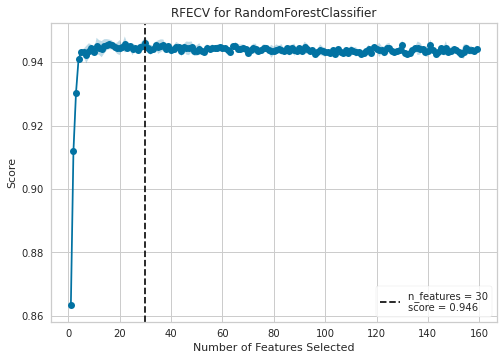

CPU times: user 4h 4min 43s, sys: 39min 9s, total: 4h 43min 53s
Wall time: 15h 13min 9s


In [59]:
%%time
rf_clf = RandomForestClassifier(random_state=2, n_jobs=-1)
visualizer_rf = rfecv(rf_clf, X=X_train_prep, y=y_train, cv=StratifiedKFold(3), scoring='f1_weighted')    

In [60]:
visualizer_rf.support_

array([ True,  True,  True, False, False, False, False,  True, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [61]:
print([x for i, x in enumerate(df_train_ohe.columns) if list(visualizer_rf.support_)[i]])
selected_rf_mask = [i for i, x in enumerate(df_train_ohe.columns) if list(visualizer_rf.support_)[i]]
print("\n")
print(selected_rf_mask)

X_train_sub = X_train_prep[:, selected_rf_mask]
X_test_sub = X_test_prep[:, selected_rf_mask]

['Fcst_MW', 'Fcst_MW_lag1', 'Fcst_MW_lag2', 'Fcst_MW_lag7', 'Fcst_MW_lag9', 'Fcst_MW_lag10', 'Fcst_MW_lag11', 'Fcst_MW_lag13', 'Fcst_MW_lag14', 'Fcst_MW_lag16', 'Fcst_MW_lag17', 'Fcst_MW_lag18', 'Fcst_MW_lag24', 'Fcst_MW_lag28', 'Fcst_MW_lag31', 'Fcst_MW_lag37', 'PE_lag24', 'PE_lag28', 'PE_lag30', 'PE_lag45', 'Actual_MW_lag24', 'Actual_MW_lag34', 'Actual_MW_lag41', 'Actual_MW_lag48', 'day_hour_rank', 'pk_hour_prob', 'Fcst_Peak_Flag_0', 'Fcst_Peak_Flag_1', 'Fcst_Peak_Flag_lag1_0', 'Fcst_Peak_Flag_lag1_1']


[0, 1, 2, 7, 9, 10, 11, 13, 14, 16, 17, 18, 24, 28, 31, 37, 49, 53, 55, 70, 74, 84, 91, 98, 99, 100, 147, 148, 149, 150]


In [62]:
print(X_train_prep.shape, X_test_prep.shape)
print(X_train_sub.shape, X_test_sub.shape)

(18248, 159) (4563, 159)
(18248, 30) (4563, 30)


In [63]:
%%time
scorer = make_scorer(f1_score)
# scorer = make_scorer(roc_auc_score)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

param_dist = {
        'class_weight':['balanced', None],
        'n_estimators': stats.randint(50, 2000),
        'max_depth': stats.randint(1, 150),
        'min_samples_leaf': stats.randint(1, 100),
        'min_samples_split': stats.randint(1, 100),
        'max_leaf_nodes': stats.randint(1, 100)
    }

rf_rndm = RandomizedSearchCV(
        rf_clf, param_distributions=param_dist,
        cv=skf, random_state=2, n_iter=100,
        scoring=scorer, error_score=0,
        verbose=True, n_jobs=-1
    )

CPU times: user 4.78 ms, sys: 0 ns, total: 4.78 ms
Wall time: 4.54 ms


In [64]:
%%time
rf_rndm.fit(X_train_sub, y_train)
print("Score: {}".format(rf_rndm.best_score_))
print(rf_rndm.best_estimator_)
print(rf_rndm.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/joblib/parallel.py", line 1061, in __call__
    self.retrieve()
  File "/opt/conda/envs/Python

Score: 0.6476252339395281
RandomForestClassifier(class_weight='balanced', max_depth=95, max_leaf_nodes=99,
                       min_samples_leaf=12, min_samples_split=22,
                       n_estimators=1351, n_jobs=-1, random_state=2)
{'class_weight': 'balanced', 'max_depth': 95, 'max_leaf_nodes': 99, 'min_samples_leaf': 12, 'min_samples_split': 22, 'n_estimators': 1351}
CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 51min 2s


In [65]:
%%time
rf_clf = rf_rndm.best_estimator_
rf_clf.fit(X_train_sub, y_train)
generate_metrics(rf_clf, X_train_sub, X_test_sub, y_train, y_test)

Train accuracy: 93.86%
Test accuracy: 92.90%
Train precision: 77.92%
Test precision: 75.71%
Train recall: 94.87%
Test recall: 89.70%
Train f1: 83.74%
Test f1: 80.68%


test prediction shape:  (4563,)
ROC AUC Score: 0.9685816419429123


[[3934  274]
 [  50  305]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4208
           1       0.53      0.86      0.65       355

    accuracy                           0.93      4563
   macro avg       0.76      0.90      0.81      4563
weighted avg       0.95      0.93      0.94      4563

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 11.1 s


Confusion matrix, without normalization


/tmp/wsuser/ipykernel_124/4278559315.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


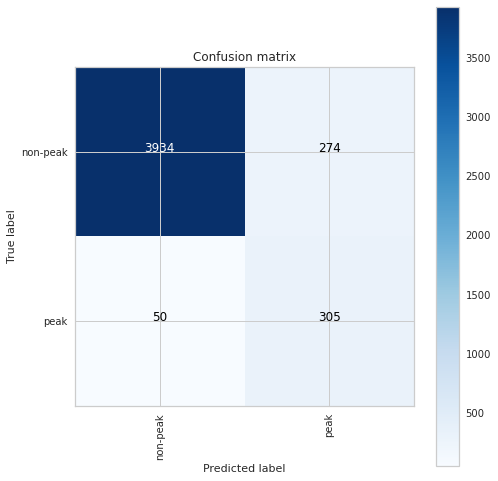

In [66]:
plt.figure(figsize = (7, 7))
plot_confusion_matrix(confusion_matrix(y_test, rf_clf.predict(X_test_sub)), classes=['non-peak', 'peak'], normalize=False,
                      title='Confusion matrix')

In [68]:
model_to_use = rf_clf

selected_feature_mask = selected_rf_mask

print(model_to_use)
print(selected_feature_mask)

RandomForestClassifier(class_weight='balanced', max_depth=95, max_leaf_nodes=99,
                       min_samples_leaf=12, min_samples_split=22,
                       n_estimators=1351, n_jobs=-1, random_state=2)
[0, 1, 2, 7, 9, 10, 11, 13, 14, 16, 17, 18, 24, 28, 31, 37, 49, 53, 55, 70, 74, 84, 91, 98, 99, 100, 147, 148, 149, 150]


In [69]:
print(target)
test_predictions = model_to_use.predict(X_test_sub)
test_predictions_prob = model_to_use.predict_proba(X_test_sub)[:,1]
true_pred_test_df = pd.DataFrame({'probs': test_predictions_prob, 'label': y_test, 'prediction': test_predictions})
true_pred_test_df['data_set'] = 'test'
print("test shape: ")
print(true_pred_test_df.shape)

train_predictions = model_to_use.predict(X_train_sub)
train_predictions_prob = model_to_use.predict_proba(X_train_sub)[:,1]
true_pred_train_df = pd.DataFrame({'probs': train_predictions_prob, 'label': y_train, 'prediction': train_predictions})
true_pred_train_df['data_set'] = 'train'
print("train shape: ")
print(true_pred_train_df.shape)

# apply model on validate set
y_validate = validate_set[target]

array_hot_encoded = ohe.transform(validate_set[categorical_features]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = feature_labels, index = validate_set.index)
df_validate_ohe = pd.concat([validate_set[numeric_features+categorical_features], data_hot_encoded], axis=1)
df_validate_ohe.drop(categorical_features, axis=1, inplace=True)

X_validate_prep = scaler.transform(df_validate_ohe)
X_validate_sub = X_validate_prep[:, selected_feature_mask]
print(X_validate_prep.shape, X_validate_sub.shape)

validate_predictions = model_to_use.predict(X_validate_sub)
validate_predictions_prob = model_to_use.predict_proba(X_validate_sub)[:,1]
true_pred_validate_df = pd.DataFrame({'probs': validate_predictions_prob, 'label': y_validate, 'prediction': validate_predictions})
true_pred_validate_df['data_set'] = 'validate'
print("validate shape: ")
print(true_pred_validate_df.shape)

two_hr_window
test shape: 
(4563, 4)
train shape: 
(18248, 4)
(10231, 159) (10231, 30)
validate shape: 
(10231, 4)


### Creating output dataframe with necessary information

In [70]:
true_pred_df = pd.concat([true_pred_train_df, true_pred_test_df, true_pred_validate_df])
print(true_pred_df.shape)

(33042, 4)


In [71]:
true_pred_df['decile'] = true_pred_df.apply(lambda x: decile(x['probs']), axis=1)
true_pred_df['correct_prediction'] = np.where(true_pred_df['prediction']==true_pred_df['label'], 1, 0)
true_pred_df.head()

,probs,label,prediction,data_set,decile,correct_prediction
13002,0.015370,0,0,train,0-9,1
4217,0.069153,0,0,train,0-9,1
14707,0.909490,1,1,train,90-100,1
15624,0.064807,0,0,train,0-9,1
18871,0.035827,0,0,train,0-9,1


In [72]:
true_pred_df = true_pred_df.join(df_lags, how='inner')
true_pred_df = true_pred_df.sort_values(by=['Date', 'HE']).reset_index(drop=True)
true_pred_df['Output_Hour'] = true_pred_df['Output_timestamp'].dt.hour
true_pred_df.head()

,probs,label,prediction,data_set,decile,correct_prediction,Output_timestamp,ahead_hours,Date,Year,month_of_year,HE,Fcst_MW,Actual_MW,PE,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob,Fcst_MW_lag1,Fcst_MW_lag2,Fcst_MW_lag3,Fcst_MW_lag4,Fcst_MW_lag5,Fcst_MW_lag6,Fcst_MW_lag7,Fcst_MW_lag8,Fcst_MW_lag9,Fcst_MW_lag10,Fcst_MW_lag11,Fcst_MW_lag12,Fcst_MW_lag13,Fcst_MW_lag14,Fcst_MW_lag15,Fcst_MW_lag16,Fcst_MW_lag17,Fcst_MW_lag18,...,PE_lag25,PE_lag26,PE_lag27,PE_lag28,PE_lag29,PE_lag30,PE_lag31,PE_lag32,PE_lag33,PE_lag34,PE_lag35,PE_lag36,PE_lag37,PE_lag38,PE_lag39,PE_lag40,PE_lag41,PE_lag42,PE_lag43,PE_lag44,PE_lag45,PE_lag46,PE_lag47,PE_lag48,Actual_MW_lag24,Actual_MW_lag25,Actual_MW_lag26,Actual_MW_lag27,Actual_MW_lag28,Actual_MW_lag29,Actual_MW_lag30,Actual_MW_lag31,Actual_MW_lag32,Actual_MW_lag33,Actual_MW_lag34,Actual_MW_lag35,Actual_MW_lag36,Actual_MW_lag37,Actual_MW_lag38,Actual_MW_lag39,Actual_MW_lag40,Actual_MW_lag41,Actual_MW_lag42,Actual_MW_lag43,Actual_MW_lag44,Actual_MW_lag45,Actual_MW_lag46,Actual_MW_lag47,Actual_MW_lag48,Output_Hour
0,0.854237,1,1,train,80-89,1,2018-07-05 14:10:43-04:00,4.0,2018-07-05,2018,7,18,11331.900,11819.272,4.123537,0,0,0,0,0,0,3.0,2.0,7.0,3,0,0,1,1,1,0.210084,0.25,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,8106.619,...,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,2.624270,11337.9400,11460.4660,11368.057,11172.056,10982.848,10565.937,10072.090,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.3750,12461.293,14
1,0.274424,0,0,train,20-29,1,2018-07-05 14:10:43-04:00,5.0,2018-07-05,2018,7,19,11027.318,11455.922,3.741331,0,0,0,0,0,0,7.0,3.0,8.0,3,0,0,0,1,1,0.000000,0.00,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,...,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,11005.7760,11337.9400,11460.466,11368.057,11172.056,10982.848,10565.937,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.375,14
2,0.085416,0,0,train,0-9,1,2018-07-05 14:10:43-04:00,6.0,2018-07-05,2018,7,20,10653.573,10921.148,2.450063,0,0,0,0,0,0,8.0,7.0,10.0,3,0,0,0,0,1,0.000000,0.00,11027.318,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,...,1.958617,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,10410.0090,11005.7760,11337.940,11460.466,11368.057,11172.056,10982.848,10565.9370,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.010,14
3,0.022543,0,0,train,0-9,1,2018-07-05 14:10:43-04:00,7.0,2018-07-05,2018,7,21,10403.465,10441.913,0.368208,0,0,0,0,0,0,10.0,8.0,11.0,3,0,0,0,0,0,0.000000,0.00,10653.573,11027.318,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,63

In [73]:
true_pred_df2 = true_pred_df[['Output_timestamp', 'Output_Hour', 'ahead_hours', 'Date', 'HE', 'Actual_MW', 'Fcst_MW', 'PE', 'day_hour_rank', 'label',  'prediction', 'correct_prediction', 'decile', 'probs']].copy()
true_pred_df2.head()

,Output_timestamp,Output_Hour,ahead_hours,Date,HE,Actual_MW,Fcst_MW,PE,day_hour_rank,label,prediction,correct_prediction,decile,probs
0,2018-07-05 14:10:43-04:00,14,4.0,2018-07-05,18,11819.272,11331.900,4.123537,3.0,1,1,1,80-89,0.854237
1,2018-07-05 14:10:43-04:00,14,5.0,2018-07-05,19,11455.922,11027.318,3.741331,7.0,0,0,1,20-29,0.274424
2,2018-07-05 14:10:43-04:00,14,6.0,2018-07-05,20,10921.148,10653.573,2.450063,8.0,0,0,1,0-9,0.085416
3,2018-07-05 14:10:43-04:00,14,7.0,2018-07-05,21,10441.913,10403.465,0.368208,10.0,0,0,1,0-9,0.022543
4,2018-07-05 14:10:43-04:00,14,8.0,2018-07-05,22,10071.330,9974.923,0.957242,11.0,0,0,1,0-9,0.012292


In [74]:
#Normalizing probability output to calculate window probabilities
true_pred_df2['norm_prob'] = true_pred_df2['probs']/true_pred_df2.groupby('Output_timestamp')['probs'].transform('sum')

#Calculating rolling window probabilities
true_pred_df2['2hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(2).sum()).shift(-1)
true_pred_df2['2hr_window'].fillna(true_pred_df2['norm_prob'], inplace=True)

true_pred_df2['3hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(3).sum()).shift(-2)
true_pred_df2['3hr_window'].fillna(true_pred_df2['2hr_window'], inplace=True)

true_pred_df2['4hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(4).sum()).shift(-3)
true_pred_df2['4hr_window'].fillna(true_pred_df2['3hr_window'], inplace=True)


true_pred_df2.head()

,Output_timestamp,Output_Hour,ahead_hours,Date,HE,Actual_MW,Fcst_MW,PE,day_hour_rank,label,prediction,correct_prediction,decile,probs,norm_prob,2hr_window,3hr_window,4hr_window
0,2018-07-05 14:10:43-04:00,14,4.0,2018-07-05,18,11819.272,11331.900,4.123537,3.0,1,1,1,80-89,0.854237,0.344785,0.455547,0.490023,0.499122
1,2018-07-05 14:10:43-04:00,14,5.0,2018-07-05,19,11455.922,11027.318,3.741331,7.0,0,0,1,20-29,0.274424,0.110762,0.145238,0.154337,0.159298
2,2018-07-05 14:10:43-04:00,14,6.0,2018-07-05,20,10921.148,10653.573,2.450063,8.0,0,0,1,0-9,0.085416,0.034476,0.043574,0.048535,0.051863
3,2018-07-05 14:10:43-04:00,14,7.0,2018-07-05,21,10441.913,10403.465,0.368208,10.0,0,0,1,0-9,0.022543,0.009099,0.014060,0.017388,0.020696
4,2018-07-05 14:10:43-04:00,14,8.0,2018-07-05,22,10071.330,9974.923,0.957242,11.0,0,0,1,0-9,0.012292,0.004961,0.008289,0.011597,0.014950


In [ ]:
# project.save_data("peakwindowsforecast_rf_2hour_JPJ_production_05262022.csv", true_pred_df2.to_csv(index=False), overwrite=True)

## LGBM with feature selection

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


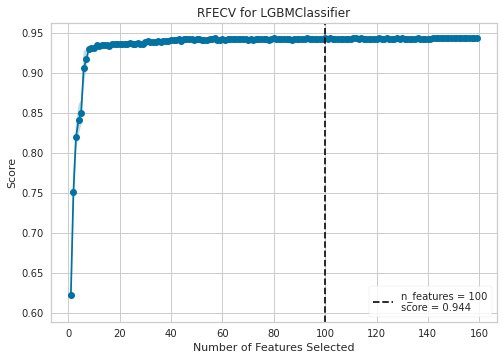

CPU times: user 2d 7h 3min 9s, sys: 25min 14s, total: 2d 7h 28min 23s
Wall time: 14h 29min 41s


In [58]:
%%time
lgb_clf = lgb.LGBMClassifier(class_weight='balanced',random_state=2, n_jobs=-1)
visualizer_lgb = rfecv(lgb_clf, X=X_train_prep, y=y_train, cv=StratifiedKFold(3), scoring='f1_weighted')  

In [59]:
visualizer_lgb.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [60]:
print([x for i, x in enumerate(df_train_ohe.columns) if list(visualizer_lgb.support_)[i]])
selected_lgb_mask = [i for i, x in enumerate(df_train_ohe.columns) if list(visualizer_lgb.support_)[i]]
print("\n")
print(selected_lgb_mask)

X_train_sub = X_train_prep[:, selected_lgb_mask]
X_test_sub = X_test_prep[:, selected_lgb_mask]

['Fcst_MW', 'Fcst_MW_lag1', 'Fcst_MW_lag2', 'Fcst_MW_lag3', 'Fcst_MW_lag4', 'Fcst_MW_lag5', 'Fcst_MW_lag6', 'Fcst_MW_lag7', 'Fcst_MW_lag8', 'Fcst_MW_lag9', 'Fcst_MW_lag10', 'Fcst_MW_lag11', 'Fcst_MW_lag12', 'Fcst_MW_lag13', 'Fcst_MW_lag14', 'Fcst_MW_lag15', 'Fcst_MW_lag16', 'Fcst_MW_lag17', 'Fcst_MW_lag18', 'Fcst_MW_lag19', 'Fcst_MW_lag20', 'Fcst_MW_lag21', 'Fcst_MW_lag22', 'Fcst_MW_lag23', 'Fcst_MW_lag24', 'Fcst_MW_lag25', 'Fcst_MW_lag26', 'Fcst_MW_lag27', 'Fcst_MW_lag28', 'Fcst_MW_lag29', 'Fcst_MW_lag30', 'Fcst_MW_lag32', 'Fcst_MW_lag33', 'Fcst_MW_lag34', 'Fcst_MW_lag35', 'Fcst_MW_lag36', 'Fcst_MW_lag37', 'Fcst_MW_lag38', 'Fcst_MW_lag39', 'Fcst_MW_lag40', 'Fcst_MW_lag41', 'Fcst_MW_lag42', 'Fcst_MW_lag43', 'Fcst_MW_lag44', 'Fcst_MW_lag45', 'Fcst_MW_lag47', 'Fcst_MW_lag48', 'PE_lag24', 'PE_lag25', 'PE_lag26', 'PE_lag27', 'PE_lag28', 'PE_lag29', 'PE_lag30', 'PE_lag31', 'PE_lag32', 'PE_lag33', 'PE_lag34', 'PE_lag35', 'PE_lag36', 'PE_lag37', 'PE_lag38', 'PE_lag39', 'PE_lag40', 'PE_lag41',

In [61]:
print(X_train_prep.shape, X_test_prep.shape)
print(X_train_sub.shape, X_test_sub.shape)

(18248, 159) (4563, 159)
(18248, 100) (4563, 100)


In [62]:
%%time
scorer = make_scorer(f1_score)
# scorer = make_scorer(roc_auc_score)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

param_dist = {
        'class_weight':['balanced', None],
        'n_estimators': stats.randint(50, 500),
        'num_leaves':stats.randint(5, 20),
        'max_depth': stats.randint(1, 100),
    }

lgb_rndm = RandomizedSearchCV(
        lgb_clf, param_distributions=param_dist,
        cv=skf, random_state=2, n_iter=100,
        scoring=scorer, error_score=0,
        verbose=True, n_jobs=-1
    )

CPU times: user 2.97 ms, sys: 23 µs, total: 2.99 ms
Wall time: 3.01 ms


In [66]:
%%time
lgb_rndm.fit(X_train_sub, y_train)
print("Score: {}".format(lgb_rndm.best_score_))

Score: 0.6811355737554007
CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 149 µs


In [68]:
%%time
lgb_clf = lgb_rndm.best_estimator_
lgb_clf.fit(X_train_sub, y_train)
generate_metrics(lgb_clf, X_train_sub, X_test_sub, y_train, y_test)

Train accuracy: 99.42%
Test accuracy: 95.00%
Train precision: 96.56%
Test precision: 81.49%
Train recall: 99.69%
Test recall: 87.23%
Train f1: 98.06%
Test f1: 84.06%


test prediction shape:  (4563,)
ROC AUC Score: 0.9712526107213624


[[4058  150]
 [  78  277]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4208
           1       0.65      0.78      0.71       355

    accuracy                           0.95      4563
   macro avg       0.81      0.87      0.84      4563
weighted avg       0.96      0.95      0.95      4563

CPU times: user 12.5 s, sys: 71.2 ms, total: 12.6 s
Wall time: 1.75 s


Confusion matrix, without normalization


/tmp/wsuser/ipykernel_1034/4278559315.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


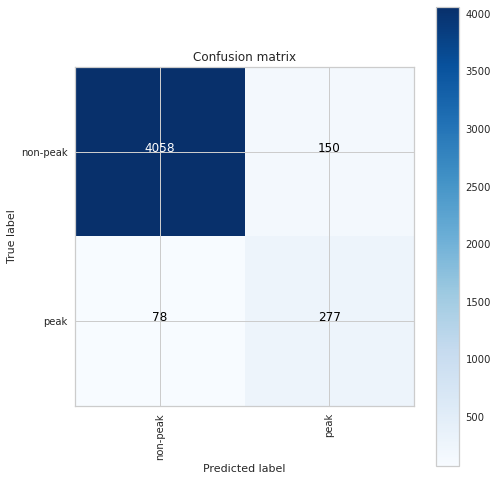

In [69]:
plt.figure(figsize = (7, 7))
plot_confusion_matrix(confusion_matrix(y_test, lgb_clf.predict(X_test_sub)), classes=['non-peak', 'peak'], normalize=False,
                      title='Confusion matrix')

In [70]:
model_to_use = lgb_clf

selected_feature_mask = selected_lgb_mask

print(model_to_use)
print(selected_feature_mask)

LGBMClassifier(class_weight='balanced', max_depth=5, n_estimators=476,
               num_leaves=16, random_state=2)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 88, 89, 91, 92, 93, 94, 96, 98, 99, 100, 130, 136, 140, 144, 149, 151, 157]


In [71]:
print(target)
test_predictions = model_to_use.predict(X_test_sub)
test_predictions_prob = model_to_use.predict_proba(X_test_sub)[:,1]
true_pred_test_df = pd.DataFrame({'probs': test_predictions_prob, 'label': y_test, 'prediction': test_predictions})
true_pred_test_df['data_set'] = 'test'
print("test shape: ")
print(true_pred_test_df.shape)

train_predictions = model_to_use.predict(X_train_sub)
train_predictions_prob = model_to_use.predict_proba(X_train_sub)[:,1]
true_pred_train_df = pd.DataFrame({'probs': train_predictions_prob, 'label': y_train, 'prediction': train_predictions})
true_pred_train_df['data_set'] = 'train'
print("train shape: ")
print(true_pred_train_df.shape)

# apply model on validate set
y_validate = validate_set[target]

array_hot_encoded = ohe.transform(validate_set[categorical_features]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = feature_labels, index = validate_set.index)
df_validate_ohe = pd.concat([validate_set[numeric_features+categorical_features], data_hot_encoded], axis=1)
df_validate_ohe.drop(categorical_features, axis=1, inplace=True)

X_validate_prep = scaler.transform(df_validate_ohe)
X_validate_sub = X_validate_prep[:, selected_feature_mask]
print(X_validate_prep.shape, X_validate_sub.shape)

validate_predictions = model_to_use.predict(X_validate_sub)
validate_predictions_prob = model_to_use.predict_proba(X_validate_sub)[:,1]
true_pred_validate_df = pd.DataFrame({'probs': validate_predictions_prob, 'label': y_validate, 'prediction': validate_predictions})
true_pred_validate_df['data_set'] = 'validate'
print("validate shape: ")
print(true_pred_validate_df.shape)

two_hr_window
test shape: 
(4563, 4)
train shape: 
(18248, 4)
(10235, 159) (10235, 100)
validate shape: 
(10235, 4)


### Creating output dataframe with necessary information

In [95]:
true_pred_df = pd.concat([true_pred_train_df, true_pred_test_df, true_pred_validate_df])
print(true_pred_df.shape)

(33046, 4)


In [96]:
true_pred_df['decile'] = true_pred_df.apply(lambda x: decile(x['probs']), axis=1)
true_pred_df['correct_prediction'] = np.where(true_pred_df['prediction']==true_pred_df['label'], 1, 0)
true_pred_df.head()

,probs,label,prediction,data_set,decile,correct_prediction
13002,0.000006,0,0,train,0-9,1
4217,0.000494,0,0,train,0-9,1
14707,0.997569,1,1,train,90-100,1
15624,0.000816,0,0,train,0-9,1
18871,0.001013,0,0,train,0-9,1


In [97]:
true_pred_df = true_pred_df.join(df_lags, how='inner')
true_pred_df = true_pred_df.sort_values(by=['Date', 'HE']).reset_index(drop=True)
true_pred_df['Output_Hour'] = true_pred_df['Output_timestamp'].dt.hour
true_pred_df.head()

,probs,label,prediction,data_set,decile,correct_prediction,Output_timestamp,ahead_hours,Date,Year,month_of_year,HE,Fcst_MW,Actual_MW,PE,Fcst_Bunch,Fcst_Bunch_lag1,Fcst_Bunch_lead1,Fcst_Peak_Flag,Fcst_Peak_Flag_lag1,Fcst_Peak_Flag_lead1,day_hour_rank,day_hour_rank_lag1,day_hour_rank_lead1,day_of_week,Is_Weekend,Peak_hr,two_hr_window,three_hr_window,four_hr_window,pk_hour_prob,pkday_hr_prob,Fcst_MW_lag1,Fcst_MW_lag2,Fcst_MW_lag3,Fcst_MW_lag4,Fcst_MW_lag5,Fcst_MW_lag6,Fcst_MW_lag7,Fcst_MW_lag8,Fcst_MW_lag9,Fcst_MW_lag10,Fcst_MW_lag11,Fcst_MW_lag12,Fcst_MW_lag13,Fcst_MW_lag14,Fcst_MW_lag15,Fcst_MW_lag16,Fcst_MW_lag17,Fcst_MW_lag18,...,PE_lag25,PE_lag26,PE_lag27,PE_lag28,PE_lag29,PE_lag30,PE_lag31,PE_lag32,PE_lag33,PE_lag34,PE_lag35,PE_lag36,PE_lag37,PE_lag38,PE_lag39,PE_lag40,PE_lag41,PE_lag42,PE_lag43,PE_lag44,PE_lag45,PE_lag46,PE_lag47,PE_lag48,Actual_MW_lag24,Actual_MW_lag25,Actual_MW_lag26,Actual_MW_lag27,Actual_MW_lag28,Actual_MW_lag29,Actual_MW_lag30,Actual_MW_lag31,Actual_MW_lag32,Actual_MW_lag33,Actual_MW_lag34,Actual_MW_lag35,Actual_MW_lag36,Actual_MW_lag37,Actual_MW_lag38,Actual_MW_lag39,Actual_MW_lag40,Actual_MW_lag41,Actual_MW_lag42,Actual_MW_lag43,Actual_MW_lag44,Actual_MW_lag45,Actual_MW_lag46,Actual_MW_lag47,Actual_MW_lag48,Output_Hour
0,0.956106,1,1,train,90-100,1,2018-07-05 14:10:43-04:00,4.0,2018-07-05,2018,7,18,11331.900,11819.272,4.123537,0,0,0,0,0,0,3.0,2.0,7.0,3,0,0,1,1,1,0.210084,0.25,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,8106.619,...,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,2.624270,11337.9400,11460.4660,11368.057,11172.056,10982.848,10565.937,10072.090,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.3750,12461.293,14
1,0.033642,0,0,train,0-9,1,2018-07-05 14:10:43-04:00,5.0,2018-07-05,2018,7,19,11027.318,11455.922,3.741331,0,0,0,0,0,0,7.0,3.0,8.0,3,0,0,0,1,1,0.000000,0.00,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,7526.538,...,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,3.502075,11005.7760,11337.9400,11460.466,11368.057,11172.056,10982.848,10565.937,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.0100,12332.375,14
2,0.001958,0,0,train,0-9,1,2018-07-05 14:10:43-04:00,6.0,2018-07-05,2018,7,20,10653.573,10921.148,2.450063,0,0,0,0,0,0,8.0,7.0,10.0,3,0,0,0,0,1,0.000000,0.00,11027.318,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,6341.239,6593.700,6980.488,...,1.958617,1.352468,1.075899,0.165965,-0.705421,2.798464,2.792294,3.223859,3.564368,4.084722,3.806074,4.068192,5.774667,3.828332,2.483078,2.872807,3.388719,2.877843,2.683056,2.844116,2.118722,2.033888,2.691638,4.223801,10410.0090,11005.7760,11337.940,11460.466,11368.057,11172.056,10982.848,10565.9370,10072.0900,9399.7227,8544.5439,7670.8887,6883.9868,6536.0024,6612.7490,6632.0664,6813.5718,7157.5244,7616.7666,8261.3291,9106.2061,9971.4697,10801.9740,11289.5930,11876.010,14
3,0.000127,0,0,train,0-9,1,2018-07-05 14:10:43-04:00,7.0,2018-07-05,2018,7,21,10403.465,10441.913,0.368208,0,0,0,0,0,0,10.0,8.0,11.0,3,0,0,0,0,0,0.000000,0.00,10653.573,11027.318,11331.900,11419.441,11269.783,11260.252,10543.092,10081.215,9549.507,8913.984,8219.697,7432.338,6545.883,5997.685,6096.129,6195.687,634

In [98]:
true_pred_df2 = true_pred_df[['Output_timestamp', 'Output_Hour', 'ahead_hours', 'Date', 'HE', 'Actual_MW', 'Fcst_MW', 'PE', 'day_hour_rank', 'label',  'prediction', 'correct_prediction', 'decile', 'probs']].copy()
true_pred_df2.head()

,Output_timestamp,Output_Hour,ahead_hours,Date,HE,Actual_MW,Fcst_MW,PE,day_hour_rank,label,prediction,correct_prediction,decile,probs
0,2018-07-05 14:10:43-04:00,14,4.0,2018-07-05,18,11819.272,11331.900,4.123537,3.0,1,1,1,90-100,0.956106
1,2018-07-05 14:10:43-04:00,14,5.0,2018-07-05,19,11455.922,11027.318,3.741331,7.0,0,0,1,0-9,0.033642
2,2018-07-05 14:10:43-04:00,14,6.0,2018-07-05,20,10921.148,10653.573,2.450063,8.0,0,0,1,0-9,0.001958
3,2018-07-05 14:10:43-04:00,14,7.0,2018-07-05,21,10441.913,10403.465,0.368208,10.0,0,0,1,0-9,0.000127
4,2018-07-05 14:10:43-04:00,14,8.0,2018-07-05,22,10071.330,9974.923,0.957242,11.0,0,0,1,0-9,0.000015


In [99]:
#Normalizing probability output to calculate window probabilities
true_pred_df2['norm_prob'] = true_pred_df2['probs']/true_pred_df2.groupby('Output_timestamp')['probs'].transform('sum')

#Calculating rolling window probabilities
true_pred_df2['2hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(2).sum()).shift(-1)
true_pred_df2['2hr_window'].fillna(true_pred_df2['norm_prob'], inplace=True)

true_pred_df2['3hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(3).sum()).shift(-2)
true_pred_df2['3hr_window'].fillna(true_pred_df2['2hr_window'], inplace=True)

true_pred_df2['4hr_window'] = true_pred_df2.groupby('Output_timestamp')['norm_prob'].transform(lambda x: x.rolling(4).sum()).shift(-3)
true_pred_df2['4hr_window'].fillna(true_pred_df2['3hr_window'], inplace=True)


true_pred_df2.head()

,Output_timestamp,Output_Hour,ahead_hours,Date,HE,Actual_MW,Fcst_MW,PE,day_hour_rank,label,prediction,correct_prediction,decile,probs,norm_prob,2hr_window,3hr_window,4hr_window
0,2018-07-05 14:10:43-04:00,14,4.0,2018-07-05,18,11819.272,11331.900,4.123537,3.0,1,1,1,90-100,0.956106,0.696495,0.721002,0.722429,0.722521
1,2018-07-05 14:10:43-04:00,14,5.0,2018-07-05,19,11455.922,11027.318,3.741331,7.0,0,0,1,0-9,0.033642,0.024507,0.025934,0.026026,0.026037
2,2018-07-05 14:10:43-04:00,14,6.0,2018-07-05,20,10921.148,10653.573,2.450063,8.0,0,0,1,0-9,0.001958,0.001427,0.001519,0.001530,0.001538
3,2018-07-05 14:10:43-04:00,14,7.0,2018-07-05,21,10441.913,10403.465,0.368208,10.0,0,0,1,0-9,0.000127,0.000093,0.000103,0.000112,0.000112
4,2018-07-05 14:10:43-04:00,14,8.0,2018-07-05,22,10071.330,9974.923,0.957242,11.0,0,0,1,0-9,0.000015,0.000011,0.000019,0.000020,0.000021


In [100]:
# two_hr = true_pred_df2.groupby(['Output_timestamp'])[['2hr_window']].idxmax()['2hr_window']
# three_hr = true_pred_df2.groupby(['Output_timestamp'])[['3hr_window']].idxmax()['3hr_window']
# four_hr = true_pred_df2.groupby(['Output_timestamp'])[['4hr_window']].idxmax()['4hr_window']

# selected_two_hr = true_pred_df2.loc[two_hr]
# selected_three_hr = true_pred_df2.loc[three_hr]
# selected_four_hr = true_pred_df2.loc[four_hr]



In [92]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='e7cb5423-6a7e-4b66-a43a-945ab9c1ff31', project_access_token='p-c0350211750f8cbcb967f8cdd40da80fd326ddf1')
pc = project.project_context

In [101]:
project.save_data("peakwindowsforecast_lgb_2hour_JPJ_05262022.csv", true_pred_df2.to_csv(index=False), overwrite=True)

{'file_name': 'peakwindowsforecast_lgb_2hour_JPJ_05262022.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'peakprediction1bdev-donotdelete-pr-uro5imnbrzzacl',
 'asset_id': '1bd63956-0c5c-4cc8-9cae-eac7cb60532a'}